# Deep Learning for Cone Cells and Light Frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

import pickle

from simulator_lib import *

2025-04-24 19:25:58.246699: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 19:25:58.399484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 19:25:58.543837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745537158.690445   18208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745537158.725121   18208 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 19:25:58.982256: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Generating / Loading the Cone Cells

In [2]:
GENERATE_NEW_CONE_CELLS = False

if GENERATE_NEW_CONE_CELLS:

    TOTAL_NUM_CELLS = 10000
    NUM_RED = int(TOTAL_NUM_CELLS * PERCENT_RED)
    NUM_GREEN = int(TOTAL_NUM_CELLS * PERCENT_GREEN)
    NUM_BLUE = int(TOTAL_NUM_CELLS * PERCENT_BLUE)
    assert(NUM_RED + NUM_GREEN + NUM_BLUE == TOTAL_NUM_CELLS)

    # create the cone cells
    cone_cells = (
        generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
        generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
        generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
    )

    # save the cone cells
    with open("./data/normal_cone_cells.pkl", "wb") as fp:
        pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    with open("./data/normal_cone_cells.pkl", mode="rb") as fp:
        cone_cells = pickle.load(fp)
    TOTAL_NUM_CELLS = len(cone_cells)

print(TOTAL_NUM_CELLS)
print(cone_cells)

10000
[<simulator_lib.ConeCell object at 0x7aa57fe3de80>, <simulator_lib.ConeCell object at 0x7aa57fb14ef0>, <simulator_lib.ConeCell object at 0x7aa5806cc0e0>, <simulator_lib.ConeCell object at 0x7aa6001429f0>, <simulator_lib.ConeCell object at 0x7aa60039aa50>, <simulator_lib.ConeCell object at 0x7aa57fbf2f60>, <simulator_lib.ConeCell object at 0x7aa57f917770>, <simulator_lib.ConeCell object at 0x7aa5816da4e0>, <simulator_lib.ConeCell object at 0x7aa57fdf2a50>, <simulator_lib.ConeCell object at 0x7aa580705340>, <simulator_lib.ConeCell object at 0x7aa5f879df10>, <simulator_lib.ConeCell object at 0x7aa5f879df40>, <simulator_lib.ConeCell object at 0x7aa5f879db80>, <simulator_lib.ConeCell object at 0x7aa5f879df70>, <simulator_lib.ConeCell object at 0x7aa5f879cda0>, <simulator_lib.ConeCell object at 0x7aa5f879c890>, <simulator_lib.ConeCell object at 0x7aa5f879e030>, <simulator_lib.ConeCell object at 0x7aa5f879c8f0>, <simulator_lib.ConeCell object at 0x7aa57fae3110>, <simulator_lib.ConeCell 

## Generating / Loading the Simulation Data

In [10]:
GENERATE_NEW_SIMULATION_DATA = False

if GENERATE_NEW_SIMULATION_DATA:

    NUM_DATA_POINTS = 1000
    MIN_WAVELENGTH = 380
    MAX_WAVELENGTH = 750

    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
        min_wl=MIN_WAVELENGTH, 
        max_wl=MAX_WAVELENGTH,
    )

    # save the simulation data
    with open("./data/normal_simulation_data.pkl", "wb") as fp:
        pickle.dump((activations, colors), fp, pickle.HIGHEST_PROTOCOL)

else:

    with open("./data/normal_simulation_data.pkl", "rb") as fp:
        activations, colors = pickle.load(fp)

colors = np.array(colors).astype(int)
print(activations)
print(colors)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[5 4 4 0 5 3 5 5 5 5 2 5 0 5 0 0 1 0 2 2 5 5 4 0 0 0 2 1 2 1 2 1 0 5 0 5 1
 2 5 0 1 2 0 3 5 5 1 0 5 2 0 3 5 2 1 4 0 4 4 2 5 0 0 2 3 5 0 2 5 5 1 5 0 1
 0 5 4 5 1 5 5 1 5 5 5 3 0 2 0 5 5 4 5 0 5 5 4 5 1 5 5 5 5 0 2 5 0 4 5 3 5
 4 5 2 5 4 1 1 2 4 2 4 5 2 0 0 1 5 5 2 0 2 2 5 5 5 5 5 5 5 5 0 1 0 5 2 4 2
 0 1 3 5 4 0 3 2 2 1 0 5 2 5 0 2 1 2 1 3 1 0 3 5 5 5 1 5 5 2 5 0 5 4 5 0 2
 2 0 0 2 3 5 5 5 1 5 5 5 2 2 5 5 2 0 5 5 0 5 0 5 5 5 5 4 3 2 2 0 0 5 5 0 0
 5 0 5 5 0 2 5 2 1 3 5 2 5 5 0 1 2 5 1 1 3 0 5 5 0 5 1 2 2 5 2 3 0 1 4 1 5
 5 5 2 5 5 0 3 2 2 0 5 5 0 0 0 1 2 5 5 2 5 2 5 0 1 1 0 5 1 5 2 3 4 5 5 5 0
 2 5 1 0 0 5 0 0 2 0 3 1 4 5 5 1 4 0 3 5 5 0 0 2 0 1 1 5 5 5 5 0 3 5 5 5 2
 5 5 5 5 2 5 0 0 5 2 1 5 1 0 4 5 0 5 0 2 3 1 5 5 1 2 2 1 5 2 4 5 4 5 3 0 2
 3 5 5 2 0 4 0 1 2 5 1 1 2 1 5 4 4 0 0 1 5 0 2 4 5 5 5 5 5 1 5 5 0 5 5 5 5
 0 5 5 0 0 5 5 1 0 

## Feedforward Network Architecture

### Separate Data into Training and Test Sets

In [ ]:
# shuffle the data
randomize = np.arange(len(activations), dtype=int)
np.random.shuffle(randomize)
activations = activations[randomize]
colors = colors[randomize]

PERCENT_TRAIN_SET = 0.85
NUM_TRAIN_SET = int(len(activations) * PERCENT_TRAIN_SET)

train_activations = activations[:NUM_TRAIN_SET]
train_colors = colors[:NUM_TRAIN_SET]
test_activations = activations[NUM_TRAIN_SET:]
test_colors = colors[NUM_TRAIN_SET:]

6

### Model Setup

In [16]:
model = keras.Sequential([
    keras.Input(shape=(train_activations.shape[-1], )),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=len(Color), activation="softmax"),
])

### Compile Model

In [17]:
optimizer = keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.004)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,438 (5.08 MB)

 Trainable params: 1,330,438 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the Model

In [19]:
EPOCHS = 10
h = model.fit(train_activations, train_colors, batch_size=64, epochs=EPOCHS, validation_split=0.1)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6438 - loss: 1.3075 - val_accuracy: 0.9765 - val_loss: 0.5022
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9640 - loss: 0.5026 - val_accuracy: 0.9882 - val_loss: 0.2390
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9700 - loss: 0.1936 - val_accuracy: 0.9882 - val_loss: 0.1109
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9778 - loss: 0.1232 - val_accuracy: 0.9882 - val_loss: 0.1099
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9718 - loss: 0.0924 - val_accuracy: 1.0000 - val_loss: 0.0427
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9900 - loss: 0.0679 - val_accuracy: 0.9882 - val_loss: 0.0543
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9892 - loss: 0.0426 - val_accuracy: 0.9882 - val_loss: 0.0744
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9864 - loss: 0.0352 - val_accuracy: 1.0000 - v

### Visualize Loss Trajectory

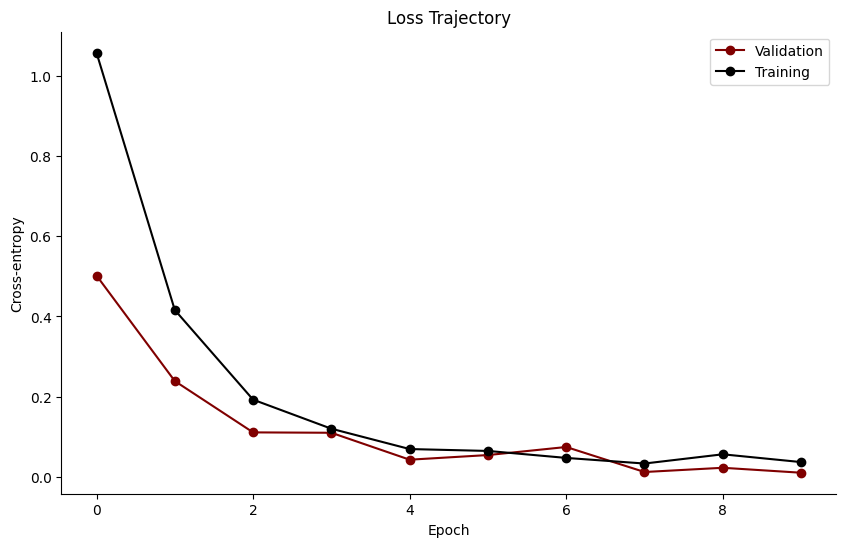

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(EPOCHS), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(EPOCHS), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

### Evaluate Model on Test Data

In [21]:
test_loss, test_accuracy = model.evaluate(test_activations, test_colors)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0034


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


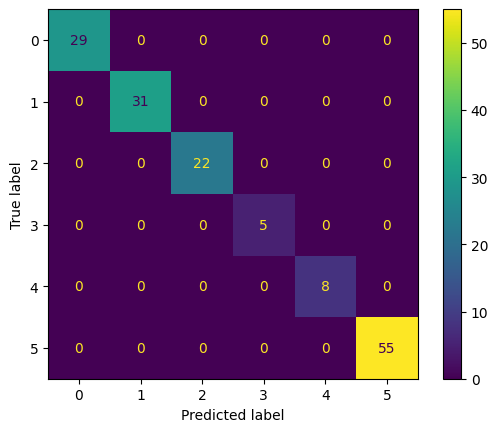

In [22]:
preds = model.predict(test_activations)
metrics.ConfusionMatrixDisplay.from_predictions(test_colors, preds.argmax(axis=1))